walmart 주단위 데이터 139주로 향후 4주 예측하기

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
tf.set_random_seed(77)
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac12.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [47]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [48]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [49]:
def LSTM(txs, forecastDay, features):
    tf.set_random_seed(77)
    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 5
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 50
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.001
    # iterations는 반복 횟수
    iterations = 2000

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY) * 0.7)
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
 
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(i, step_loss))
       

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY,originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed) #실제 sales 파란색
        plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return (test_predict), realSale




[[  8.68174327e-05   3.47269731e-05   0.00000000e+00   3.49006079e-02
    4.32776220e-01]
 [  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]] -> [ 0.36538662  0.38436925  0.45543053  0.99420598  0.74595118]
[[  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]
 [  1.73634865e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.65386619e-01]] -> [ 0.38436925  0.45543053  0.99

[[  4.51450650e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.83600256e-01]
 [  4.68814136e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    3.07138546e-01]
 [  4.86177623e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.97798379e-01]
 [  5.03541109e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.66710967e-01]
 [  5.20904596e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.67082024e-01]] -> [ 0.30400704  0.26976607  0.27330354  0.27423665  0.28201393]
[[  4.68814136e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    3.07138546e-01]
 [  4.86177623e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.97798379e-01]
 [  5.03541109e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.66710967e-01]
 [  5.20904596e-04   1.21544406e-04   3.47269731e-05   3.49006079e-02
    2.67082024e-01]
 [  5.38268083e-04   1.38907892e-04   3.47269731e-05   3.49006079e-02
    3.04007041e-01]] -> [ 0.26976607  0.27330354  0.27

[step: 28] loss: 19.306413650512695
[step: 29] loss: 18.44464683532715
[step: 30] loss: 17.73210906982422
[step: 31] loss: 17.143980026245117
[step: 32] loss: 16.651260375976562
[step: 33] loss: 16.224824905395508
[step: 34] loss: 15.839726448059082
[step: 35] loss: 15.47846794128418
[step: 36] loss: 15.132477760314941
[step: 37] loss: 14.801651000976562
[step: 38] loss: 14.492301940917969
[step: 39] loss: 14.21430778503418
[step: 40] loss: 13.978111267089844
[step: 41] loss: 13.792136192321777
[step: 42] loss: 13.66098690032959
[step: 43] loss: 13.584487915039062
[step: 44] loss: 13.557740211486816
[step: 45] loss: 13.571860313415527
[step: 46] loss: 13.615320205688477
[step: 47] loss: 13.675477027893066
[step: 48] loss: 13.74010944366455
[step: 49] loss: 13.79865837097168
[step: 50] loss: 13.843069076538086
[step: 51] loss: 13.868156433105469
[step: 52] loss: 13.87162971496582
[step: 53] loss: 13.85374927520752
[step: 54] loss: 13.816844940185547
[step: 55] loss: 13.76469898223877
[s

[step: 275] loss: 12.217620849609375
[step: 276] loss: 12.211552619934082
[step: 277] loss: 12.20548152923584
[step: 278] loss: 12.199413299560547
[step: 279] loss: 12.19334888458252
[step: 280] loss: 12.187286376953125
[step: 281] loss: 12.181224822998047
[step: 282] loss: 12.175176620483398
[step: 283] loss: 12.169129371643066
[step: 284] loss: 12.163091659545898
[step: 285] loss: 12.15706729888916
[step: 286] loss: 12.151053428649902
[step: 287] loss: 12.14505386352539
[step: 288] loss: 12.139065742492676
[step: 289] loss: 12.133095741271973
[step: 290] loss: 12.127141952514648
[step: 291] loss: 12.121207237243652
[step: 292] loss: 12.11529541015625
[step: 293] loss: 12.109405517578125
[step: 294] loss: 12.103533744812012
[step: 295] loss: 12.097688674926758
[step: 296] loss: 12.091874122619629
[step: 297] loss: 12.086079597473145
[step: 298] loss: 12.080322265625
[step: 299] loss: 12.074590682983398
[step: 300] loss: 12.068890571594238
[step: 301] loss: 12.063224792480469
[step: 30

[step: 523] loss: 10.975737571716309
[step: 524] loss: 10.968048095703125
[step: 525] loss: 10.960282325744629
[step: 526] loss: 10.952445983886719
[step: 527] loss: 10.944534301757812
[step: 528] loss: 10.936541557312012
[step: 529] loss: 10.928475379943848
[step: 530] loss: 10.920328140258789
[step: 531] loss: 10.912102699279785
[step: 532] loss: 10.903792381286621
[step: 533] loss: 10.895401000976562
[step: 534] loss: 10.886924743652344
[step: 535] loss: 10.878362655639648
[step: 536] loss: 10.86971378326416
[step: 537] loss: 10.860977172851562
[step: 538] loss: 10.85214614868164
[step: 539] loss: 10.843223571777344
[step: 540] loss: 10.834213256835938
[step: 541] loss: 10.825103759765625
[step: 542] loss: 10.815898895263672
[step: 543] loss: 10.806595802307129
[step: 544] loss: 10.79719352722168
[step: 545] loss: 10.787688255310059
[step: 546] loss: 10.778078079223633
[step: 547] loss: 10.768362998962402
[step: 548] loss: 10.758541107177734
[step: 549] loss: 10.748610496520996
[ste

[step: 780] loss: 7.730630397796631
[step: 781] loss: 7.724091053009033
[step: 782] loss: 7.715076923370361
[step: 783] loss: 7.70706844329834
[step: 784] loss: 7.701653480529785
[step: 785] loss: 7.696874141693115
[step: 786] loss: 7.6904215812683105
[step: 787] loss: 7.682443618774414
[step: 788] loss: 7.674859523773193
[step: 789] loss: 7.668772220611572
[step: 790] loss: 7.663452625274658
[step: 791] loss: 7.657582759857178
[step: 792] loss: 7.650674819946289
[step: 793] loss: 7.643311023712158
[step: 794] loss: 7.6363630294799805
[step: 795] loss: 7.630152702331543
[step: 796] loss: 7.62436580657959
[step: 797] loss: 7.61850118637085
[step: 798] loss: 7.612246990203857
[step: 799] loss: 7.605597019195557
[step: 800] loss: 7.598761081695557
[step: 801] loss: 7.5919694900512695
[step: 802] loss: 7.585367679595947
[step: 803] loss: 7.578975200653076
[step: 804] loss: 7.572747230529785
[step: 805] loss: 7.566636562347412
[step: 806] loss: 7.560614109039307
[step: 807] loss: 7.55471897

[step: 1010] loss: 6.406316757202148
[step: 1011] loss: 6.393552780151367
[step: 1012] loss: 6.387823104858398
[step: 1013] loss: 6.386660099029541
[step: 1014] loss: 6.385006427764893
[step: 1015] loss: 6.378548622131348
[step: 1016] loss: 6.3677144050598145
[step: 1017] loss: 6.355954170227051
[step: 1018] loss: 6.347413063049316
[step: 1019] loss: 6.342732906341553
[step: 1020] loss: 6.339299201965332
[step: 1021] loss: 6.3340959548950195
[step: 1022] loss: 6.325907230377197
[step: 1023] loss: 6.316404819488525
[step: 1024] loss: 6.307928562164307
[step: 1025] loss: 6.30160665512085
[step: 1026] loss: 6.296586990356445
[step: 1027] loss: 6.291141510009766
[step: 1028] loss: 6.284274578094482
[step: 1029] loss: 6.276197910308838
[step: 1030] loss: 6.2680983543396
[step: 1031] loss: 6.260894298553467
[step: 1032] loss: 6.254659652709961
[step: 1033] loss: 6.2487473487854
[step: 1034] loss: 6.24240255355835
[step: 1035] loss: 6.235348701477051
[step: 1036] loss: 6.2278032302856445
[ste

[step: 1260] loss: 4.775381565093994
[step: 1261] loss: 4.772002696990967
[step: 1262] loss: 4.7681379318237305
[step: 1263] loss: 4.763875484466553
[step: 1264] loss: 4.759560585021973
[step: 1265] loss: 4.755500793457031
[step: 1266] loss: 4.751809120178223
[step: 1267] loss: 4.748380184173584
[step: 1268] loss: 4.744993686676025
[step: 1269] loss: 4.741460800170898
[step: 1270] loss: 4.737720012664795
[step: 1271] loss: 4.733841896057129
[step: 1272] loss: 4.7299652099609375
[step: 1273] loss: 4.726208209991455
[step: 1274] loss: 4.722610950469971
[step: 1275] loss: 4.71912956237793
[step: 1276] loss: 4.715677738189697
[step: 1277] loss: 4.7121806144714355
[step: 1278] loss: 4.708602428436279
[step: 1279] loss: 4.7049641609191895
[step: 1280] loss: 4.701312065124512
[step: 1281] loss: 4.697696208953857
[step: 1282] loss: 4.694142818450928
[step: 1283] loss: 4.690649032592773
[step: 1284] loss: 4.687193393707275
[step: 1285] loss: 4.683742046356201
[step: 1286] loss: 4.68027257919311

[step: 1509] loss: 3.9208743572235107
[step: 1510] loss: 3.918333053588867
[step: 1511] loss: 3.9158425331115723
[step: 1512] loss: 3.9128994941711426
[step: 1513] loss: 3.9095706939697266
[step: 1514] loss: 3.906294584274292
[step: 1515] loss: 3.903378486633301
[step: 1516] loss: 3.90073299407959
[step: 1517] loss: 3.898038864135742
[step: 1518] loss: 3.8951001167297363
[step: 1519] loss: 3.8919801712036133
[step: 1520] loss: 3.888904333114624
[step: 1521] loss: 3.8860154151916504
[step: 1522] loss: 3.883270740509033
[step: 1523] loss: 3.880528211593628
[step: 1524] loss: 3.877673387527466
[step: 1525] loss: 3.874716281890869
[step: 1526] loss: 3.8717429637908936
[step: 1527] loss: 3.868844747543335
[step: 1528] loss: 3.8660354614257812
[step: 1529] loss: 3.863272190093994
[step: 1530] loss: 3.860490322113037
[step: 1531] loss: 3.8576571941375732
[step: 1532] loss: 3.8547847270965576
[step: 1533] loss: 3.8519091606140137
[step: 1534] loss: 3.8490676879882812
[step: 1535] loss: 3.84627

[step: 1728] loss: 3.4024546146392822
[step: 1729] loss: 3.3996167182922363
[step: 1730] loss: 3.39778995513916
[step: 1731] loss: 3.396376132965088
[step: 1732] loss: 3.3944239616394043
[step: 1733] loss: 3.391791582107544
[step: 1734] loss: 3.3891372680664062
[step: 1735] loss: 3.387004852294922
[step: 1736] loss: 3.385263204574585
[step: 1737] loss: 3.3834023475646973
[step: 1738] loss: 3.3811378479003906
[step: 1739] loss: 3.378654956817627
[step: 1740] loss: 3.3763091564178467
[step: 1741] loss: 3.374255418777466
[step: 1742] loss: 3.3723347187042236
[step: 1743] loss: 3.3703038692474365
[step: 1744] loss: 3.3680648803710938
[step: 1745] loss: 3.3657233715057373
[step: 1746] loss: 3.3634426593780518
[step: 1747] loss: 3.3613009452819824
[step: 1748] loss: 3.3592493534088135
[step: 1749] loss: 3.3571743965148926
[step: 1750] loss: 3.3550095558166504
[step: 1751] loss: 3.352761745452881
[step: 1752] loss: 3.350490093231201
[step: 1753] loss: 3.3482587337493896
[step: 1754] loss: 3.3

[step: 1966] loss: 2.8687121868133545
[step: 1967] loss: 2.8663055896759033
[step: 1968] loss: 2.863898754119873
[step: 1969] loss: 2.8614919185638428
[step: 1970] loss: 2.8590846061706543
[step: 1971] loss: 2.856675386428833
[step: 1972] loss: 2.8542685508728027
[step: 1973] loss: 2.8518595695495605
[step: 1974] loss: 2.8494508266448975
[step: 1975] loss: 2.847043752670288
[step: 1976] loss: 2.844632625579834
[step: 1977] loss: 2.8422231674194336
[step: 1978] loss: 2.8398141860961914
[step: 1979] loss: 2.8374037742614746
[step: 1980] loss: 2.834994077682495
[step: 1981] loss: 2.8325846195220947
[step: 1982] loss: 2.8301761150360107
[step: 1983] loss: 2.827768087387085
[step: 1984] loss: 2.8253626823425293
[step: 1985] loss: 2.8229644298553467
[step: 1986] loss: 2.820582866668701
[step: 1987] loss: 2.8182294368743896
[step: 1988] loss: 2.8159396648406982
[step: 1989] loss: 2.8137974739074707
[step: 1990] loss: 2.8119890689849854
[step: 1991] loss: 2.8109583854675293
[step: 1992] loss: 

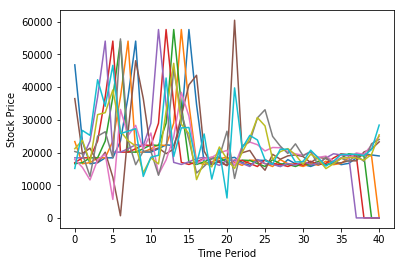

In [50]:
answer=LSTM(txs,5,'WeekNumber_Month_Season_Year' )

In [51]:
len(answer)

2

In [52]:
predict=answer[0]

In [53]:
real=answer[1]

In [54]:
predict[-1]

array([ 23261.93359375,  24913.92578125,  23989.33789062,  25383.453125  ,
        28381.8203125 ], dtype=float32)

In [144]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [126]:
denormalizedTestPredictY

[15798.604,
 14722.048,
 15121.582,
 14954.279,
 17118.977,
 15644.573,
 15849.232,
 15525.247,
 14816.899,
 14112.375,
 14630.68,
 16013.2,
 17937.387,
 19444.676,
 19259.762,
 18787.432,
 24630.928,
 23599.018,
 24115.422,
 18142.271,
 61038.18,
 28532.447,
 15645.645,
 19705.068,
 21329.863,
 30300.719,
 40043.18,
 36211.652,
 22588.805]

In [ ]:
denormalizedTestY=originalSales[train_size+seq_length:]

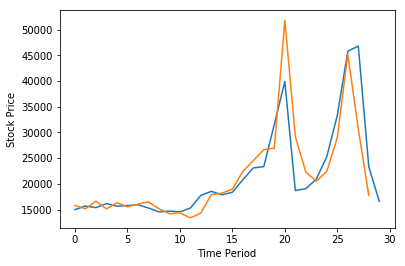

In [3]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [4]:
print(i for i in list(test_predict[-1]    ))

<generator object <genexpr> at 0x000000000CA1B1A8>


In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY